Introduction


The dataset provided includes the abundance of Eulaema nigrita in the Brazilian Atlantic forest. It also includes a number of predictor variables including the climate (mean annual temperature and precipitation, temperature and precipitation seasonality), and land use (proportional forest cover and land use heterogeneity defined as the Shannon diversity of local land-use classes).

The climate data from Worldclim dataset are much used in eco studies. The mean annual temp is given in degrees C, the annual precip in mm, the temp seasonality (Tseason) as 100 times the SD of the monthly temp, and the precip seasonality (Pseason) as the CV of monthly precipitation (percent (ie times 100)). 

Why is the temp seasonality measured as a SD and the precipitation as a CV?

temperature varies around a mean and SD captures the absolute variation - this will tell us how much temperatures vary from the annual mean

precipitation is measured with the coefficient of variation (SD/mean) because precipitation varies a LOT depending on the location - using just SD would skew data for wetter areas. CV standardizes by the mean giving a relative variation 

the effort variable in the log number of hours of sampling and the method variable indicates whether the collecting was done with hand nets, traps, or a combo of both


In [ ]:
install.packages("tidyverse") #installed to parse through the df neatly
install.packages(c("gt", "webshot2"))  #installed to make tables to then export
install.packages("car") # to calc VIF
install.packages("MASS") # fitting glm.nb
install.packages("ggeffects") # ggpredict 

In [ ]:
library(ggplot2) #load in ggplot2 library for plotting
library(tibble) #load in to convert df to tibbles for tidyverse compatability
library(dplyr) #load in to neatly group data by column in the tibble
library(broom) #load in the convert linear model output into df
library(gt) #loaded in to create tables
library(car) # VIF
library(MASS) #glm.nb
library(ggeffects) #used in partial effects

In [ ]:
# saving data
dat = read.csv("/Users/emmabolech/Desktop/BIOS15/251119/Eulaema.csv")


In [ ]:
#explore the structure of the data
print(str(dat))

In [ ]:
# exploring what the data looks like
print(head(dat))

In [ ]:
# printing a summary or the data
print(summary(dat))

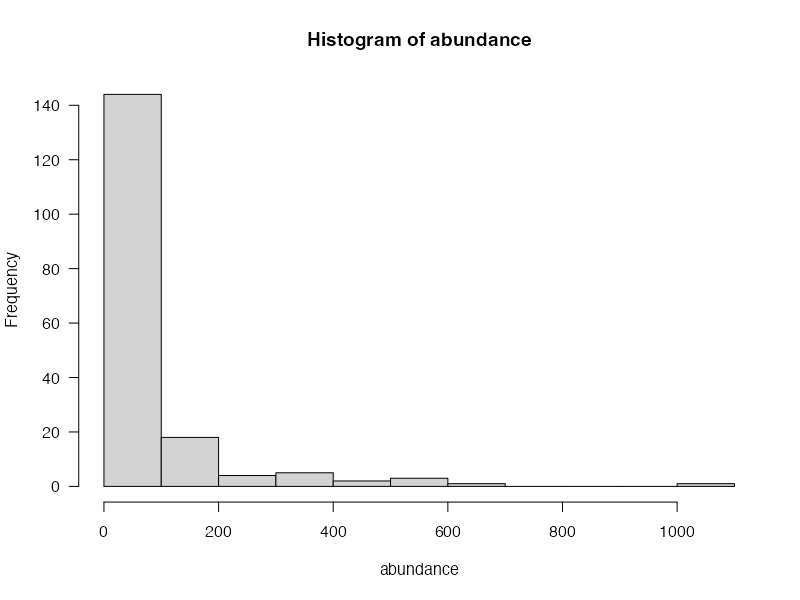

In [33]:
# look at the bee abundance with a histogram --> lots of abundance measures between 0-100 ish 

abundance = dat$Eulaema_nigrita #saves the abundance column as a variable

hist(abundance, las = 1) #plots a histogram (las just changes the axis orientation)

In [ ]:
# look at variance and mean to check for overdispersion

print(var(abundance))
print(mean(abundance))

# variance is much larger than the mean so there is overdispersion


In [ ]:
# for SA (sampling area) and SU (sampling unit) these are categorical identifies but not predictor variables

#adjust continuous predictors 

dat$altitude_std = as.numeric(scale(dat$altitude))
dat$MAT_std = as.numeric(scale(dat$MAT))
dat$MAP_std = as.numeric(scale(dat$MAP))
dat$Tseason_std = as.numeric(scale(dat$Tseason))
dat$Pseason_std = as.numeric(scale(dat$Pseason))
dat$forest_std = as.numeric(scale(dat$forest.))
dat$forest = dat$forest.
dat$lu_het_std = as.numeric(scale(dat$lu_het))
dat$effort_std = as.numeric(scale(dat$effort))

# adjust categorical predictors 

#first look at all unique entries in the method column
method_types = unique(dat$method)
print(method_types)

# this will then output effect relative to the ref category (which is NetTraps)
dat$method = factor(dat$method)

dat$method = relevel(dat$method, ref = "NetTraps")



In [ ]:
# correlation of |0.7-0.8| == strong cor

# excluded method bc pairs is designed for continous numeric variables

predictors = c("altitude_std", "MAT_std", "MAP_std", "Tseason_std", "Pseason_std", "forest_std", "lu_het_std", "effort_std")

cor(dat[, predictors])

In [ ]:
# fitting negative binomial glm
m_std = glm.nb(Eulaema_nigrita~effort_std+altitude_std+MAT_std+MAP_std+Tseason_std+Pseason_std+forest_std+lu_het_std+method, data=dat)


In [ ]:
# pseudo r^2 is around 0.48 which is ok (between 0-1) (48% of the deviance is explained by the model)
1 - (m_std$deviance/m_std$null.deviance)


In [ ]:
#overdispersion looks ok with the nb glm choice 

dev <- m_std$deviance
df  <- m_std$df.residual

overdispersion <- dev / df
overdispersion

In [ ]:
# check variance inflation factor if greater than 5 there may be collinearity 
vif_values = vif(m_std)

print(vif_values)

# when including methods (this is a multi-level factor) none of them have a strong vif but due to the correlation above i will choose to throw out altitude and keep MAT

In [ ]:
# chose to do a negative binomial bc overdispersion is so strong

# this will assume the mean as the variance 

# theta is 1.09 which is close to 1 and indicates high variance compared to mean

# using nb the SE will be larger 

# i cut altitude and chose to use standardized values so that i can more easily compare the effects
m_std_final = glm.nb(Eulaema_nigrita~effort_std+MAT_std+MAP_std+Tseason_std+Pseason_std+forest_std+lu_het_std+method, data=dat)

print(summary(m_std_final))

# Interpreting the negative binomial model: the intercept shows the log-count at (exp(intercept) = 0) (predictors are 0) to be 4.00. theta is 1.09 which shows a strong overdispersion in the data and affirms that nb is the better model to choose.


In [ ]:
# tidy model into a tibble
tidy_m = broom::tidy(m_std_final)

#generate a table that includes the exp effect
exp_table = tidy_m %>%
  as_tibble() %>%
  dplyr::rename(z.value = statistic) %>%
  mutate(exp_estimate = exp(estimate)) %>%
  dplyr::select(term, estimate, std.error, z.value, p.value, exp_estimate)


print(exp_table, width = Inf)

1. effort : 94% increase in bee counts with 1 SD increase in effort
2. MAT : a 6% decrease in bee counts with a 1 SD increase in MAT (however, this is insignificant)
3. MAP : a 43% decrease in bee counts with a 1 SD increase in MAP
4. Tseason : a 38% decrease in bee counts with a 1 SD increase in Tseason
5. Pseason : a 35% increase in bee counts with a 1 SD increase in Pseason 
6. forest. : a 27% decrease in bee counts with a 1 SD increase in forest cover 
7. lu_het : a 45 decrease but NOT significant
8. methodNet : a 0% change and also insignificant 
9. methodTraps :  a 29% decreases in bee counts but insignnificant
10. ** NetTraps are exluded bc they are the reference 

*** based on this I will be excluding the insignificant predictors moving forward (MAT, lu_het, and methods)

*** when i re-did with altitude included and MAT excluded --> this was effectively the same insignificant result 

In [34]:
# refitting without MAT and lu_het (due to insignificance)

m_std_refit = glm.nb(Eulaema_nigrita~effort_std+MAP_std+Tseason_std+Pseason_std+forest_std, data=dat)

print(summary(m_std_refit))




Call:
glm.nb(formula = Eulaema_nigrita ~ effort_std + MAP_std + Tseason_std + 
    Pseason_std + forest_std, data = dat, init.theta = 1.076928683, 
    link = log)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.93316    0.07364  53.409  < 2e-16 ***
effort_std   0.56720    0.07904   7.176 7.19e-13 ***
MAP_std     -0.51120    0.08066  -6.338 2.33e-10 ***
Tseason_std -0.42352    0.08168  -5.185 2.16e-07 ***
Pseason_std  0.33103    0.08000   4.138 3.51e-05 ***
forest_std  -0.27033    0.08084  -3.344 0.000826 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.0769) family taken to be 1)

    Null deviance: 378.07  on 177  degrees of freedom
Residual deviance: 205.26  on 172  degrees of freedom
AIC: 1775.9

Number of Fisher Scoring iterations: 1


              Theta:  1.077 
          Std. Err.:  0.111 

 2 x log-likelihood:  -1761.935 


In [ ]:
# quick AIC check to make sure the reduced model is preferred

AIC_check = AIC(m_std_final, m_std_refit)

deltaAIC = AIC_check$AIC[1] - AIC_check$AIC[2]

print(deltaAIC)

# a bit higher than 2 so slightly better to drop the two insignificant factors 

In [ ]:
# rechecking VIF for collinearity, looks ok
vif(m_std_refit)

In [ ]:
# re checking pseudo R^2 
ps2_refit = 1 - (m_std_refit$deviance/m_std_refit$null.deviance)

print(ps2_refit)
# pseudo r^2 is around 0.45 which is ok (between 0-1) (45% of the deviance is explained by the model)

In [ ]:
# rechecking overdispersion for the refit model 
dev_refit <- m_std$deviance
df_refit  <- m_std$df.residual

overdispersion_refit <- dev / df
overdispersion_refit

In [ ]:
# generating a tidy table with the exponentiated estimates
tidy_m_refit = broom::tidy(m_std_refit)

exp_table_refit_exp = tidy_m_refit %>%
  as_tibble() %>%
  dplyr::rename(z.value = statistic) %>%
  mutate(exp_estimate = exp(estimate)) %>%
  dplyr::select(term, estimate, std.error, z.value, p.value, exp_estimate)


print(exp_table_refit_exp, width = Inf)

In [ ]:
# showing exponentiated values as a forest plot that is ordered 

tidy_m_refit <- broom::tidy(m_std_refit, conf.int = TRUE) #adding conf intervals 

# Build the table
exp_table_refit <- tidy_m_refit %>%
  filter(term != "(Intercept)") %>%              # remove intercept
  mutate(
    z.value = statistic,
    exp_estimate = exp(estimate),
    exp_conf.low = exp(conf.low), # adding confidence innterval error bars
    exp_conf.high = exp(conf.high),
    term = dplyr::recode(term, # renaming 
      "effort_std"   = "Effort",
      "MAP_std"      = "MAP",
      "Tseason_std"  = "T Seasonality",
      "Pseason_std"  = "P Seasonality",
      "forest_std"   = "Forest Cover"
    )
  )

# Forest plot
ggplot(exp_table_refit, aes(
    x = reorder(term, exp_estimate), # reordering based on the ordered exp_estimate numbers
    y = exp_estimate)
) +
  geom_point(size = 3, color = "red") +
  geom_errorbar(aes(ymin = exp_conf.low, ymax = exp_conf.high),
                width = 0.1, linewidth = 0.8) +
  geom_hline(yintercept = 1, linetype = "dashed") + # adding the line that denoted insignnificance (exp(0))
  labs(
    x = "Predictor",
    y = "Effect size (exp(b))",
    title = "Standardized Predictors Effect Size"
  ) +
  theme(
    panel.background = element_rect(fill = "white"),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_line(color = "grey90"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    legend.position = "none",
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 14, face = "bold"), 
    axis.title.y = element_text(size = 14, face = "bold"), 
    axis.text.x = element_text(size = 14, face = "bold"),
    axis.text.y = element_text(size = 14, face = "bold")) 


In [ ]:
# ggpredict inncludes SE and 95% CI (and reverts to response scale)

effort_predict = ggpredict(m_std_refit, terms = "effort_std")

MAP_predict = ggpredict(m_std_refit, terms = "MAP_std")

Tseason_predict = ggpredict(m_std_refit, terms = "Tseason_std")

Pseason_predict = ggpredict(m_std_refit, terms = "Pseason_std")

forest_predict = ggpredict(m_std_refit, terms = "forest_std")

#plotting all 
effort_plot = ggplot(effort_predict, aes(x = x, y = predicted)) +
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high), fill = "skyblue") + #this adds the confience interval ribbon around the model line
  geom_line(color = "black", linewidth = 1.5) + # model prediction
  geom_point(data = dat, aes(x = effort_std, y = abundance), color = "gray") + # adding raw data
  labs(
    x = "Standardized Effort",
    y = "Predicted Abundance", 
    title = "Partial Effect of Effort on Bee Abundance"
  ) +
  theme(
    panel.background = element_rect(fill = "white"),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_line(color = "grey90"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    legend.position = "none",
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 14, face = "bold"), 
    axis.title.y = element_text(size = 14, face = "bold"), 
    axis.text.x = element_text(size = 14, face = "bold"),
    axis.text.y = element_text(size = 14, face = "bold")) 

# repeat the same for all predictors 
MAP_plot = ggplot(MAP_predict, aes(x = x, y = predicted)) +
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high), fill = "skyblue") +
  geom_line(color = "black", linewidth = 1.5) + # model prediction
  geom_point(data = dat, aes(x = effort_std, y = abundance), color = "gray") + # adding raw data
  labs(
    x = "Standardized MAP",
    y = "Predicted Abundance", 
    title = "Partial Effect of MAP on Bee Abundance"
  ) +
  theme(
    panel.background = element_rect(fill = "white"),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_line(color = "grey90"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    legend.position = "none",
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 14, face = "bold"), 
    axis.title.y = element_text(size = 14, face = "bold"), 
    axis.text.x = element_text(size = 14, face = "bold"),
    axis.text.y = element_text(size = 14, face = "bold"))

Tseason_plot = ggplot(Tseason_predict, aes(x = x, y = predicted)) +
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high), fill = "skyblue") +
  geom_line(color = "black", linewidth = 1.5) + # model prediction
  geom_point(data = dat, aes(x = effort_std, y = abundance), color = "gray") + # adding raw data
  labs(
    x = "Standardized Tseason",
    y = "Predicted Abundance", 
    title = "Partial Effect of Temperature Seasonality on Bee Abundance"
  ) +
  theme(
    panel.background = element_rect(fill = "white"),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_line(color = "grey90"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    legend.position = "none",
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 14, face = "bold"), 
    axis.title.y = element_text(size = 14, face = "bold"), 
    axis.text.x = element_text(size = 14, face = "bold"),
    axis.text.y = element_text(size = 14, face = "bold"))

Pseason_plot = ggplot(Pseason_predict, aes(x = x, y = predicted)) +
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high), fill = "skyblue") +
  geom_line(color = "black", linewidth = 1.5) + # model prediction
  geom_point(data = dat, aes(x = effort_std, y = abundance), color = "gray") + # adding raw data
  labs(
    x = "Standardized Pseason",
    y = "Predicted Abundance", 
    title = "Partial Effect of Precipication Seasonality on Bee Abundance"
  ) +
  theme(
    panel.background = element_rect(fill = "white"),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_line(color = "grey90"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    legend.position = "none",
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 14, face = "bold"), 
    axis.title.y = element_text(size = 14, face = "bold"), 
    axis.text.x = element_text(size = 14, face = "bold"),
    axis.text.y = element_text(size = 14, face = "bold"))

forest_plot = ggplot(forest_predict, aes(x = x, y = predicted)) +
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high), fill = "skyblue") +
  geom_line(color = "black", linewidth = 1.5) + # model prediction
  geom_point(data = dat, aes(x = effort_std, y = abundance), color = "gray") + # adding raw data
  labs(
    x = "Standardized Forest Cover",
    y = "Predicted Abundance", 
    title = "Partial Effect of Forest Cover on Bee Abundance"
  ) +
  theme(
    panel.background = element_rect(fill = "white"),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_line(color = "grey90"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    legend.position = "none",
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 14, face = "bold"), 
    axis.title.y = element_text(size = 14, face = "bold"), 
    axis.text.x = element_text(size = 14, face = "bold"),
    axis.text.y = element_text(size = 14, face = "bold"))


In [ ]:
# creating the plotted panel 

effort_plot 
MAP_plot 
Tseason_plot 
Pseason_plot 
forest_plot

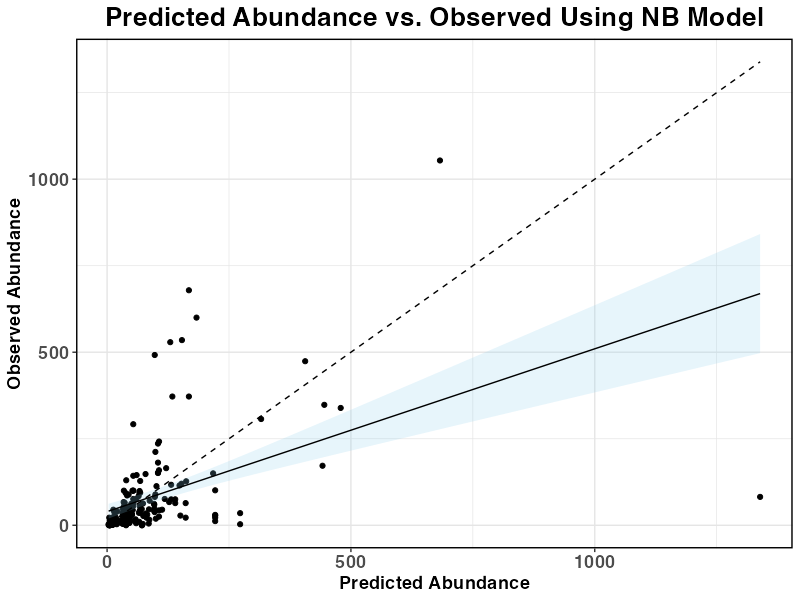

In [40]:
# all predicted values for entire model against observed

predicted_values = predict(m_std_refit, type = "response")
dat$predicted_values = predicted_values
dat$observed = abundance

# model fit line with a confidence interval shadding
fit_line <- lm(observed ~ predicted_values, data = dat)
pred_fit_line <- data.frame(
  predicted_values = seq(min(dat$predicted_values), max(dat$predicted_values), length.out = 100)
)
pred_fit_line$fit <- predict(fit_line, newdata = pred_fit_line, interval = "confidence")[, "fit"]
pred_fit_line$lwr <- predict(fit_line, newdata = pred_fit_line, interval = "confidence")[, "lwr"]
pred_fit_line$upr <- predict(fit_line, newdata = pred_fit_line, interval = "confidence")[, "upr"]

# perfect prediction line 1:1
perfect_df <- data.frame(
  x = seq(min(dat$predicted_values), max(dat$predicted_values), length.out = 100),
  y = seq(min(dat$predicted_values), max(dat$predicted_values), length.out = 100),
  line_type = "Perfect predictions"
)

# plotting 
ggplot() +
  geom_point(
    data = dat, 
    aes(x = predicted_values, y = observed)
  ) +
  geom_ribbon(
    data = pred_fit_line, 
    aes(x = predicted_values, ymin = lwr, ymax = upr),
    fill = "skyblue",
    alpha = 0.2, 
    inherit.aes = FALSE
  ) + 
  geom_line(
     data = pred_fit_line, 
     aes(x = predicted_values, y = fit), 
     color = "black"
  ) +
  geom_line(
    data = perfect_df, 
    aes(x = x, y = y), 
    linetype = "dashed"
  ) +
  labs(
    x = "Predicted Abundance",
    y = "Observed Abundance", 
    title = "Predicted Abundance vs. Observed Using NB Model",
  ) +
  theme(
    panel.background = element_rect(fill = "white"),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_line(color = "grey90"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    legend.position = "none",
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 14, face = "bold"), 
    axis.title.y = element_text(size = 14, face = "bold"), 
    axis.text.x = element_text(size = 14, face = "bold"),
    axis.text.y = element_text(size = 14, face = "bold"))



In [ ]:
# outputting the summary tables 

all_predictor_table = exp_table %>%   
    #change the axis labels to be a bit clearer for the reader
    #mutate(term = recode(term,
      #"(Intercept)" = "BarbareaM:BarbareaL",
      
    #open a gt table
    gt() %>%
    tab_header(title = "NB GLM for All Predictors") %>%
    #change decimal output of the following
    fmt_number(
      columns = c(estimate, std.error, z.value, p.value, exp_estimate), 
      decimals = 3) %>%
    #make p value scientific 
    fmt_scientific(
      columns = c(p.value),
      decimals = 2) %>%
    cols_label(
      term = "",
      estimate = "Estimate",
      std.error = "SE",
      z.value = "z-value",
      p.value = "p-Value",
      exp_estimate = "Exp Estimate"
    )


gtsave(all_predictor_table, "all_predictor_table.png", zoom = 4)

In [ ]:
# outputting the summary tables 

refit_predictor_table = exp_table_refit_exp %>%   
    #change the axis labels to be a bit clearer for the reader
    #mutate(term = recode(term,
      #"(Intercept)" = "BarbareaM:BarbareaL",
      
    #open a gt table
    gt() %>%
    tab_header(title = "NB GLM for Significant Predictors") %>%
    #change decimal output of the following
    fmt_number(
      columns = c(estimate, std.error, z.value, p.value, exp_estimate), 
      decimals = 3) %>%
    #make p value scientific 
    fmt_scientific(
      columns = c(p.value),
      decimals = 2) %>%
    cols_label(
      term = "",
      estimate = "Estimate",
      std.error = "SE",
      z.value = "z-value",
      p.value = "p-Value",
      exp_estimate = "Exp Estimate"
    )


gtsave(refit_predictor_table, "refit_predictor_table.png", zoom = 4)